[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/086_dlops_config/086_dlops_config.ipynb)

# DLOps - Configuración

Seguimos en nuesto viaje a través del mundo del DLOps. Si bien en el [post](https://juansensio.com/blog/087_dlops_intro) anterior vimos qué es el DLOps y cómo podemos versionar datasets, ahora es el turno de entrenar nuestros primeros modelos. Para ello usaremos la librería de [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/), una librería de código abierto que nos permite entrenar modelos por encima de [Pytorch](https://pytorch.org/) ofreciendo muchísima funcionalidad extra que nos hará la vida más fácil a la hora de entrenar y manejar nuestros modelos.

> En este post no aprenderemos a usar `Pytorch Ligthning` ya que esto lo hemos visto en este mismo blog en posts anteriores. Si no conoces esta herramienta, te aconsejo que primero le eches un vistazo a los posts anteriores.

## Primer entrenamiento

El siguiente código nos permite entrenar un primer modelo con el dataset MNIST que desarrollamos en el post anterior. Como vimos, empezaremos haciendo un clasificador binario sencillo que detecte simplemente el dígito 3 (más adelante usaremos todo el dataset para clasificación multiclase, aprendiendo por el camino como generar nuevas versiones del dataset y recetas de entrenamiento). El modelo que usaremos será un Perceptrón Multicapa sencillo.

In [9]:
import pytorch_lightning as pl 
from torch.utils.data import Dataset, DataLoader
from skimage.io import imread
import torch 
import pandas as pd
from glob import glob

class MSNITDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = imread(self.images[idx])
        return torch.from_numpy(img), self.labels[idx]

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, path, batch_size):
        super().__init__()
        self.path = path
        self.batch_size = batch_size
    def generate_df(self, l1, l2):
        return pd.DataFrame({
            'image': l1 + l2, 
            'label': [1] * len(l1) + [0] * len(l2)
        })
    def setup(self, stage = None):
        train_3 = glob(str(self.path / 'train' / '3' / '*.png'))
        train_no3 = glob(str(self.path / 'train' / 'no3' / '*.png'))
        self.train_df = self.generate_df(train_3, train_no3)
        test_3 = glob(str(self.path / 'test' / '3' / '*.png'))
        test_no3 = glob(str(self.path / 'test' / 'no3' / '*.png'))
        self.test_df = self.generate_df(test_3, test_no3)
        self.train_ds = MSNITDataset(self.train_df.image.values, self.train_df.label.values)
        self.test_ds = MSNITDataset(self.test_df.image.values, self.test_df.label.values)
    def train_dataloader(self):
        return DataLoader(self.train_ds, shuffle=True, batch_size=self.batch_size)
    def val_dataloader(self, batch_size=None, shuffle=False):
        return DataLoader(
            self.test_ds, 
            batch_size=self.batch_size if batch_size is None else batch_size,
            shuffle=shuffle
        )


In [10]:
from pathlib import Path

path = Path('dataset')

dm = MNISTDataModule(path, batch_size=25)
dm.setup()

imgs, labels = next(iter(dm.train_dataloader()))

imgs.shape, imgs.dtype, imgs.max(), imgs.min(), labels.shape

(torch.Size([25, 28, 28]),
 torch.uint8,
 tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 torch.Size([25]))

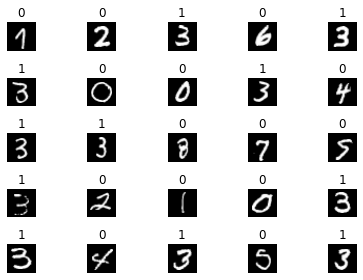

In [11]:
import matplotlib.pyplot as plt

r, c = 5, 5 
fig, axs = plt.subplots(r, c)
imgs, labels = next(iter(dm.train_dataloader()))
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(imgs[i * c + j], cmap='gray')
        axs[i, j].set_title(labels[i * c + j].item())
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class MNISTModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(28 * 28, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        x = x.float() / 255 
        return self.mlp(x.view(x.size(0), -1)).squeeze(-1)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return torch.sigmoid(self(x))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        preds = torch.sigmoid(y_hat) > 0.5
        acc = (preds.long() == y).float().mean()
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        preds = torch.sigmoid(y_hat) > 0.5
        acc = (preds.long() == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [13]:
module = MNISTModule()
module

MNISTModule(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [14]:
output = module(imgs)
output.shape

torch.Size([25])

In [15]:
dm = MNISTDataModule(path, batch_size=25)
module = MNISTModule()
trainer = pl.Trainer(
    max_epochs=10,
    logger=None,
    enable_checkpointing=False,
    # overfit_batches=1,
)
trainer.fit(module, dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 78.6 K
------------------------------------
78.6 K    Trainable params
0         Non-trainable params
78.6 K    Total params
0.314     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Tras entrenar durante 10 epochs, hemos conseguido un modelo con un 95% de precisión en los datos de test.

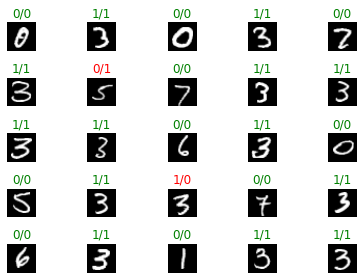

In [16]:
r, c = 5, 5 
fig, axs = plt.subplots(r, c)
imgs, labels = next(iter(dm.val_dataloader(25, True)))
preds = module.predict(imgs) > 0.5
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(imgs[i * c + j], cmap='gray')
        label = labels[i * c + j].item()
        pred = preds[i * c + j].long().item()
        axs[i, j].set_title(f'{label}/{pred}', color = 'green' if label == pred else 'red')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

## Script de entrenamiento

Si bien usar notebooks para explorar nuestros datos y probar algunos modelos, a la hora de escalar el entrenamiento querrás utilizar `scripts` de Python. Para ello te suguiero la siguiente distribución de archivo y carpetas:

- `main.py`: Contiene el código de entrenamiento.
- `src`: Contiene los archivos de código de Pytorch Lightning.
    - `dm.py`: Contiene el LightningDataModule.
    - `module.py`: Contiene el LightningModule.

Para nuestro primer caso es suficiente, pero a medida que un proyecto vaya creciendo es posible que quieras ir añandiendo archivos adicionales en la carpeta `src`, por ejemplo para separar los datasets y modelos o añadir funcionalidades extra en un archivo `utils.py`.

> Recuerda que puedes encontrar el contenido de estos archivos en el siguiente [repo](https://github.com/juansensio/dlops). 

A continuación puedes encontrar el código de entrenamiento (el contenido del archivo `main.py`)

In [ ]:
from src import *
from pathlib import Path
import pytorch_lightning as pl

path = Path('dataset')
dm = MNISTDataModule(path, batch_size=25)
module = MNISTModule()
trainer = pl.Trainer(
    max_epochs=10,
    logger=None,
    enable_checkpointing=False,
    # overfit_batches=1,
)
trainer.fit(module, dm)

Que se puede ejectuar con el comando

```
python main.py
```

Esto entrenará nuestro modelo de la misma manera que hemos visto anteriormente. Sin embargo, esto no es muy útil ya que siempre entrenaremos el mismo modelo (el cual ni siquiera estamos guardando). Necesitamos dotar de flexibilidad a nuestro `script` además de querer `trackear` todo lo que vamos haciendo. Esto lo vamos a conseguir utilizando un archivo de `configuración`.

## Archivo de configuración

Existen diferentes alternativas a la hora de ejectuar entrenamientos con archivos de configuración. Una librería bastante utilizada es [Hydra](https://hydra.cc/docs/intro/). Tras usarla un tiempo no me acaba de convencer, así que en este post explicaré mi aproximación que es la que me funciona mejor. Aún así te recomiendo que le eches un vistazo.

### Configuración base

Lo primer que necesitaremos es una configuración base en la que definiremos todos los parámetros por defecto que queremos usar en nuestro entrenamiento.

In [ ]:
config = {
    'datamodule': {
        'path': Path('dataset'),
        'batch_size': 25
    },
    'trainer': {
        'max_epochs': 10,
        'logger': None,
        'enable_checkpointing': False,
        'overfit_batches': 0
    }
}

dm = MNISTDataModule(**config['datamodule'])
module = MNISTModule()
trainer = pl.Trainer(**config['trainer'])
trainer.fit(module, dm)

Utilizando el operador `**` podemos pasar un diccionario de parámetros a una función.

> Te recomiendo no usar parámetros por defecto en tus `modules`, ya que esto puede causar problemas a largo plazo. Es un poco más tedioso pero vale la pena para `trackear` todos los parámetros usados en el entrenamiento.

## Sobreescribir la configuración base

Ahora lo que haremos será crear un archivo `config.yml` que contenga la configuración que queremos usar en nuestro entrenamiento. Para no tener que escribir todo el código de configuración, simplemente definiremos aquellos parámetros que queremos modificar de la configuración base. De este manera, nuestro proyecto quedará como:

- `main.py`: Contiene el código de entrenamiento.
- `config.yml`: Contiene la configuración del entrenamiento.
- `src`: Contiene los archivos de código de Pytorch Lightning.
    - `dm.py`: Contiene el LightningDataModule.
    - `module.py`: Contiene el LightningModule.
    - `utils.py`: Contiene funciones utiles.

El siguiente ejemplo hará un entrenamiento durante más epochs y con un `batch_size` más grande.

```
datamodule:
  batch_size: 32

trainer:
  max_epochs: 20
```

En nuestro script de entrenamiento, simplemente cargaremos la configuración del archivo, sobreescribiremos la configuración base y ejecutaremos el entrenamiento.

In [ ]:
from src import *
from pathlib import Path
import pytorch_lightning as pl
import yaml
import sys

config = {
    'datamodule': {
        'path': Path('dataset'),
        'batch_size': 25
    },
    'trainer': {
        'max_epochs': 10,
        'logger': None,
        'enable_checkpointing': False,
        'overfit_batches': 0
    }
}


def train(config):
    dm = MNISTDataModule(**config['datamodule'])
    module = MNISTModule()
    trainer = pl.Trainer(**config['trainer'])
    trainer.fit(module, dm)


if __name__ == '__main__':
    if len(sys.argv) > 1:
        config_file = sys.argv[1]
        if config_file:
            with open(config_file, 'r') as stream:
                loaded_config = yaml.safe_load(stream)
            deep_update(config, loaded_config)
    print(config)
    train(config)

## Generando diferentes experimentos

Con este `setup` ya tenemos todo lo necesario para generar diferentes experimentos. Simplemente haremos un archivo de configuración nuevo para cada experimento que queramos ejecutar. De esta manera, siempre tendremos a mano los hiperparámetros usados en un entrenamiento para poder comparar resultados y querdarnos con los mejores. Un proyecto típico tendrá la siguiente estructura:

- `main.py`: Contiene el código de entrenamiento.
- `src`: Contiene los archivos de código de Pytorch Lightning.
    - `dm.py`: Contiene el LightningDataModule.
    - `module.py`: Contiene el LightningModule.
    - `utils.py`: Contiene funciones utiles.
- `experiments`: Contiene los archivos de configuración de los experimentos.
    - `001.yml`: Contiene la configuración del entrenamiento 1.
    - `002.yml`: Contiene la configuración del entrenamiento 2.
    - `003.yml`: Contiene la configuración del entrenamiento 3.
    - ...
    - `debug.yml`: Contiene la configuración del entrenamiento para debug.

> Te aconsejo tener un archivo de `debug.yml` que te permita hacer el fit de unos batches para comprobar que tu código funciona bien.

Puedes ejectuar los experimentos con el comando

```
python main.py experiments/001.yml
```


## Consejos finales

Para sacar el máximo provecho a nuestro sistema de configuración, te recomiendo usar una funcionalidad de `Pytorch Lightning` muy útil, que es la de guardar los hiperparámetros en el mismo `checkpoint` del modelo.

In [ ]:
class MNISTModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        # ...

De esta manera, al cargar cualquier modelo que hayas entrenado con este sistema, podrás acceder a los hiperparámetros que usaste en el entrenamiento.

In [ ]:
# ...

def train(config):
    dm = MNISTDataModule(**config['datamodule'])
    module = MNISTModule(config)
    trainer = pl.Trainer(**config['trainer'])
    trainer.fit(module, dm)
    trainer.save_checkpoint('final.ckpt')

# ...

In [1]:
from src import MNISTModule

module = MNISTModule.load_from_checkpoint('final.ckpt')
module.hparams

"datamodule": {'path': PosixPath('dataset'), 'batch_size': 32}
"trainer":    {'max_epochs': 10, 'logger': None, 'enable_checkpointing': True, 'overfit_batches': 0}

En el siguiente posts veremos como mejorar nuestro script de entrenamiento para añadir funcionalidades interesantes en el ciclo de DLOps tales como `trackear` los resultados de los experimentos de manera efectiva, guardar y versionar los modelos entrenados para poder ponerlos en producción.